In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')


train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [25]:
plt.rc('font', family='NanumBarunGothic')

In [26]:
'''
id: 데이터 고유 id
age: 나이
sex: 성별 (여자 = 0, 남자 = 1)
cp: 가슴 통증(chest pain) 종류
  0 : asymptomatic 무증상
  1 : atypical angina 일반적이지 않은 협심증
  2 : non-anginal pain 협심증이 아닌 통증
  3 : typical angina 일반적인 협심증
trestbps: (resting blood pressure) 휴식 중 혈압(mmHg)
chol: (serum cholestoral) 혈중 콜레스테롤 (mg/dl)
fbs: (fasting blood sugar) 공복 중 혈당 (120 mg/dl 이하일 시 = 0, 초과일 시 = 1)
restecg: (resting electrocardiographic) 휴식 중 심전도 결과
  0: showing probable or definite left ventricular hypertrophy by Estes' criteria
  1: 정상
  2: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
thalach: (maximum heart rate achieved) 최대 심박수
exang: (exercise induced angina) 활동으로 인한  협심증 여부 (없음 = 0, 있음 = 1)
oldpeak: (ST depression induced by exercise relative to rest) 휴식 대비 운동으로 인한 ST 하강
slope: (the slope of the peak exercise ST segment) 활동 ST 분절 피크의 기울기
  0: downsloping 하강
  1: flat 평탄
  2: upsloping 상승
ca: number of major vessels colored by flouroscopy 형광 투시로 확인된 주요 혈관 수 (0~3 개)
  Null 값은 숫자 4로 인코딩됨
thal: thalassemia 지중해빈혈 여부
  0 = Null
  1 = normal 정상
  2 = fixed defect 고정 결함
  3 = reversable defect 가역 결함
target: 심장 질환 진단 여부
  0: < 50% diameter narrowing
  1: > 50% diameter narrowing
'''
# target -> 이진 분류
# 연속형 변수 age, trestbps, chol, thalach, oldpeak
# 범주형 변수 sex, cp, fbs, restecg, exang, slope, ca, thal

train.info() # object타입 존재 x, thal = 0 -> Null, ca = 4 -> Null
train.describe()

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        151 non-null    int64  
 1   age       151 non-null    int64  
 2   sex       151 non-null    int64  
 3   cp        151 non-null    int64  
 4   trestbps  151 non-null    int64  
 5   chol      151 non-null    int64  
 6   fbs       151 non-null    int64  
 7   restecg   151 non-null    int64  
 8   thalach   151 non-null    int64  
 9   exang     151 non-null    int64  
 10  oldpeak   151 non-null    float64
 11  slope     151 non-null    int64  
 12  ca        151 non-null    int64  
 13  thal      151 non-null    int64  
 14  target    151 non-null    int64  
dtypes: float64(1), int64(14)
memory usage: 17.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----

### Target의 분포확인

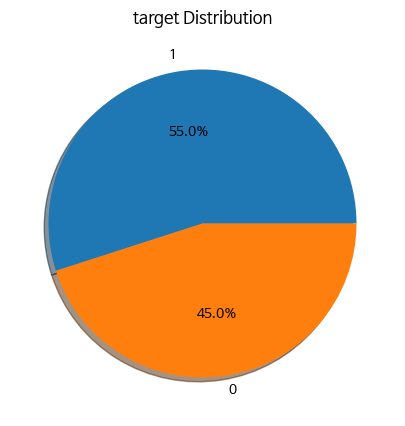

In [30]:
def pie_chart(df, col):
  categories = df[col].value_counts().index
  values = df[col].value_counts().values
  plt.figure(figsize=(10,5))
  pie_chart = plt.pie(x=values, labels=categories, autopct='%.1f%%', shadow=True)
  plt.title(f'{col} Distribution')
  plt.show()

pie_chart(train, 'target') # 1 55%, 0 45%

### 피처 컬럼 분포확인

In [44]:
# ca: 4 → 결측값 취급, 중앙값 대체
ca_median = train['ca'][train['ca'] != 4].median()
train['ca'] = train['ca'].replace(4, int(ca_median))
test['ca'] = test['ca'].replace(4, int(ca_median))

# thal: 0 → 결측값, 중앙값 대체
thal_median = train['thal'][train['thal'] != 0].median()
train['thal'] = train['thal'].replace(0, int(thal_median))
test['thal'] = test['thal'].replace(0, int(thal_median))

In [45]:
# 이상치 계산하는 함수
def calculate_outliers_IQR(df, col):
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  lb = Q1 - 1.5 * IQR
  ub = Q3 + 1.5 * IQR

  return lb, ub

In [50]:
# IQR+히스토그램을 이용한 이상치 탐지함수
def plot_histograms_with_iqr(df, feature_columns, nrows=4, ncols=4, figsize=(14, 14)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    for i, col in enumerate(feature_columns):
        lower_bound, upper_bound = calculate_outliers_IQR(df, col)
        sns.histplot(x=col, data=df, ax=axes[i], kde=True)
        axes[i].axvline(x=lower_bound, color='r', linestyle='--', label='Lower Bound')
        axes[i].axvline(x=upper_bound, color='r', linestyle='--', label='Upper Bound')
        axes[i].set_title(f'Distribution of {col}')
        axes[i].legend()
    # 사용하지 않은 subplot 삭제
    for j in range(len(feature_columns), len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle('Distribution of Features with IQR Bounds')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

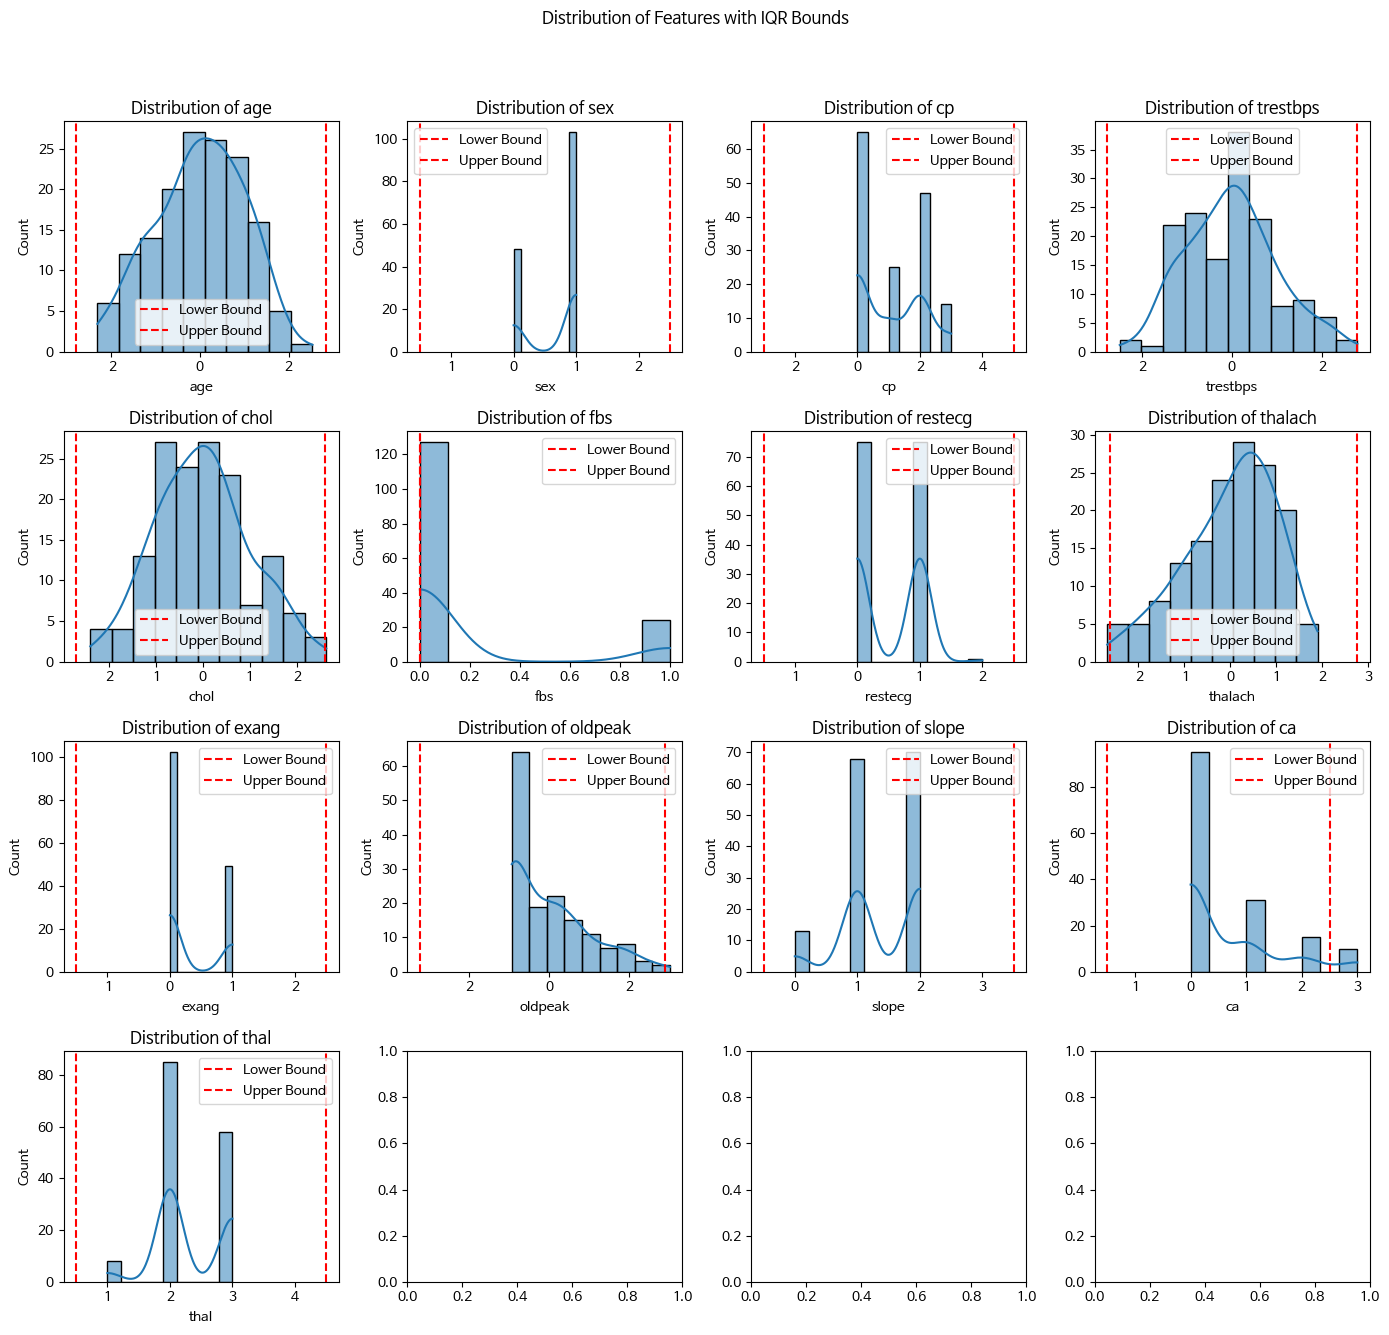

In [62]:
feature_columns = train.drop(['id', 'target'], axis=1)

plot_histograms_with_iqr(train, feature_columns)

# -> trestbps, oldpeak, chol, ca에서 이상치 발견 -> ca를 제외한 컬럼 이상치 처리

### 이상치 처리 -> 각 값의 평균으로 처리

In [48]:
outlier_columns = ['trestbps', 'oldpeak', 'chol']

def replace_outliers_with_mean(df, col):
    lower_bound, upper_bound = calculate_outliers_IQR(df, col)
    mean_value = df[(df[col] >= lower_bound) & df[col] <= upper_bound][col].mean()
    df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), mean_value, df[col])

for col in outlier_columns:
    replace_outliers_with_mean(train, col)
    replace_outliers_with_mean(test, col)

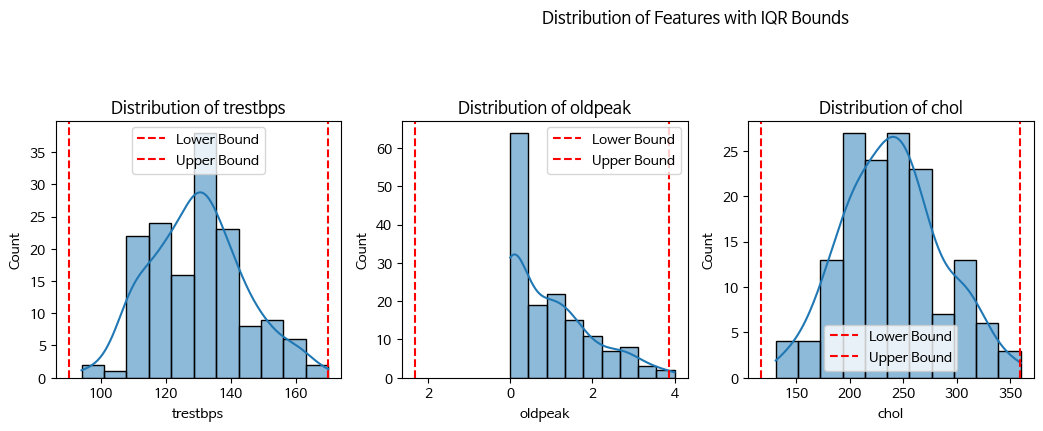

In [51]:
plot_histograms_with_iqr(train, outlier_columns)

### 연속형 변수 표준화

In [53]:
need_scaling_cols = ['age', 'trestbps', 'thalach', 'chol', 'oldpeak']

scaler = StandardScaler()
train[need_scaling_cols] = scaler.fit_transform(train[need_scaling_cols])
test[need_scaling_cols] = scaler.transform(test[need_scaling_cols])

### 모델 학습

In [57]:
X = train.drop(['id', 'target'], axis=1)
y = train['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [58]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_val)

print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71        14
           1       0.76      0.76      0.76        17

    accuracy                           0.74        31
   macro avg       0.74      0.74      0.74        31
weighted avg       0.74      0.74      0.74        31



In [59]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'class_weight': [None, 'balanced']  # 클래스 불균형 대응
}

grid = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid,
                    scoring='f1',
                    cv=5,
                    verbose=1)

grid.fit(X_train, y_train)
print(grid.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'class_weight': None, 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}


In [60]:
best_params = {
    'n_estimators': 300,
    'max_depth': None,
    'min_samples_split': 2,
    'class_weight': None
}

model = RandomForestClassifier(**best_params, random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_val)

print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.73      0.79      0.76        14
           1       0.81      0.76      0.79        17

    accuracy                           0.77        31
   macro avg       0.77      0.78      0.77        31
weighted avg       0.78      0.77      0.77        31



###제출용 파일 생성

In [61]:
test_pred = model.predict(test.drop('id', axis=1))
submission['target'] = test_pred
submission.to_csv('submission.csv', index=False)